<a href="https://colab.research.google.com/github/pavlo-seimskyi/filler-sound-detector/blob/fine-tune-mlp-model/notebooks/4-fine-tune-mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get source code and install dependencies

Install PyTorch and other dependencies

In [1]:
%%capture
!pip install torch -U
!pip install torchaudio -U
!pip3 install pickle5

Clone Git repository with the code

In [2]:
%%capture
# Generate a public key
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

In [3]:
!cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDBJtzFENH3vIZe2y+mRdy8n8KVyrrfE7khxoy/h3/az0thJqJ97pBO/16Hc3v10IDiKMLDFJmdWbSTdNha6Zn0wqc1lX3/B37UiUeO0D/IUsM8tD8//Ws3OP5gtPXoj7p1W64ezPNAxTToghsIbOrKab2wM7ns5gVxk+UpHMVPmNNxNlHahbxaTXbjdJkb84m7V0NrUvrNY1e0GWp8Tz5sk7auQHJrTbTGNVI3TKGU4vDwOGONrZaSak5wC3Ur+183FaRabE0pnZjIv2ckhwuTLU0ylpytamB7LWXeU+tBkLsuvL9eLr3uJo65oC2dnOhpD4bepaXgs4WRH2G6JtJQOqJrtF9tCbvtKPDQlqZuOsIFPpL8HyC2kmYOfixJHH/hOk5s/Sm3QJastu+OOPCqVQl3kTZQRypb/XPpiuLnf7yk4v+0InKFODD/i7t2PKVzBsXvFA6nGN7IdQk/Iv9Egxl9q81pJJ2aqHjo7cdM7xpmcfn3KO6kRTk7uDDRTh+wcyzwLlMoOBrxI212IeWsP/W5HcmgRasWewuz/GYvcd3R/WO9q4hmR4EppdXpuOrwF8AKyJCXbwfflMQQwa3S2OgJLe4Ferk7GTL4giY6bFxdQYi+ixTd2KRZhsEAVJGqP+U0uel5EX5GFCRARjo2xf1qzLMnzPikTPkrjz8WZw== root@a26eca3cece4


Add the key following [this documentation ](https://docs.github.com/en/github/authenticating-to-github/adding-a-new-ssh-key-to-your-github-account)


In [4]:
# Test SSH connection
!ssh -T git@github.com

Hi pavlo-seimskyi! You've successfully authenticated, but GitHub does not provide shell access.


In [6]:
# !rm -rf /content/filler-sound-detector
# %cd /content

/content


In [7]:
!git config --global user.email "pavseim@gmail.com"
!git config --global user.name "pavlo-seimskyi"
!git clone git@github.com:pavlo-seimskyi/filler-sound-detector.git
!cd filler-sound-detector && git checkout fine-tune-mlp-model

Cloning into 'filler-sound-detector'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 179 (delta 66), reused 74 (delta 39), pack-reused 67
Receiving objects: 100% (179/179), 2.03 MiB | 1.41 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Branch 'fine-tune-mlp-model' set up to track remote branch 'fine-tune-mlp-model' from 'origin'.
Switched to a new branch 'fine-tune-mlp-model'


Log in to gDrive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
os.chdir("filler-sound-detector")

import shutil
import pickle5 as pickle
import logging

import torch
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

['.gitignore', 'constants.py', 'poetry.lock', 'img', 'pyproject.toml', '.git', 'test', 'README.md', 'notebooks', 'clients', 'src']


In [10]:
from src.preprocess.normalizer import Normalizer
from src.evaluate.evaluate import convert_target_to_binary
from src import evaluate
from src.utils import load_pickle
from constants import BASE_PATH, FILLER_LABELING_THRESHOLD
from src.model.multi_layer_perceptron import MultiLayerPerceptron

In [11]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={
        'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w',
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR
    }
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [12]:
# What GPU am I using?
torch.cuda.get_device_name(0)

'Tesla T4'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data for training

## Copy processed data from gDrive

In [14]:
# Source
GDRIVE_FOLDER = "/content/drive/MyDrive/data-science/filler-sound-detector/data"
FEATURES_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "features")
TARGETS_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "targets")

# Destination
FEATURES_PATH = "data/features"
TARGETS_PATH = "data/targets"

In [15]:
feature_files = os.listdir(FEATURES_SRC_FOLDER)
target_files = os.listdir(TARGETS_SRC_FOLDER)

In [16]:
os.makedirs(FEATURES_PATH, exist_ok=True)
os.makedirs(TARGETS_PATH, exist_ok=True)

In [17]:
%%time
for features, targets in zip(feature_files, target_files):
    features_src = os.path.join(FEATURES_SRC_FOLDER, features)
    features_dst = os.path.join(FEATURES_PATH, features)

    targets_src = os.path.join(TARGETS_SRC_FOLDER, targets)
    targets_dst = os.path.join(TARGETS_PATH, targets)
    shutil.copy(src=features_src, dst=features_dst)
    shutil.copy(src=targets_src, dst=targets_dst)

CPU times: user 10.8 ms, sys: 110 ms, total: 120 ms
Wall time: 215 ms


---

## Read data

In [18]:
def read_pickle(path):
    with open(path, 'rb') as handle:
        return pickle.load(handle)

In [19]:
%%time
x = torch.tensor([])
y = torch.tensor([])

for speaker_filename in os.listdir(FEATURES_PATH):
    current_x = read_pickle(f"{FEATURES_PATH}/{speaker_filename}")
    current_y = read_pickle(f"{TARGETS_PATH}/{speaker_filename}")

    x = torch.concat((x, current_x), dim=1)
    y = torch.concat((y, current_y), dim=0)

CPU times: user 269 ms, sys: 125 ms, total: 393 ms
Wall time: 394 ms


---

## Train-test split & normalize

In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x.transpose(0, 1),
    convert_target_to_binary(y, threshold=FILLER_LABELING_THRESHOLD), 
    test_size=0.33,
    shuffle=False,
)

In [21]:
normalizer = Normalizer()

In [22]:
x_train = normalizer.fit_transform(x_train)
x_valid = normalizer.transform(x_valid)

In [23]:
x_train.mean(), x_train.std()

(tensor(4.8533e-09), tensor(1.))

In [24]:
x_valid.mean(), x_valid.std()

(tensor(0.0420), tensor(0.8737))

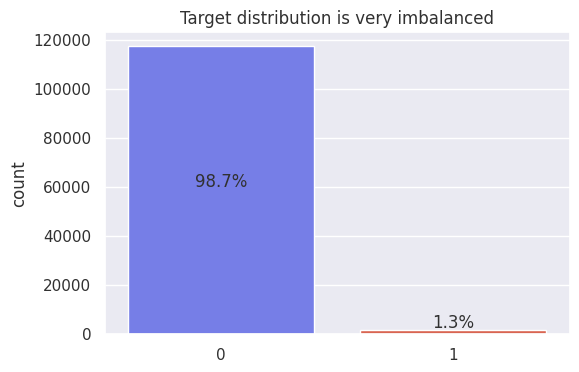

In [25]:
fig,ax = plt.subplots()
sns.countplot(x=y_valid.numpy().astype(int), ax=ax)

# show the count in %
for p in ax.patches:
    h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
    xy_ = (x_ + w_ / 2., h_ / 2)
    pct = 100 * h_ / y_valid.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(s=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")
plt.show()

# Train multi-layer perceptron

In [36]:
mlp_model = MultiLayerPerceptron(
    n_features=x_train.size(1), 
    n_hidden=512, 
    n_out=1,
    main_metric="avg_precision_score", 
    batch_size=256,
    dropout_proba=0.2,
    learning_rate=3e-4,
    weight_decay=1e-4,
)

2


In [38]:
mlp_model = mlp_model.to(device)

In [39]:
mlp_model.fit(x_train, y_train, x_valid, y_valid, n_epochs=20)

epoch: 1 | train loss: 0.01 | valid loss: 0.0144 | train avg_precision_score: 0.0961 | valid avg_precision_score: 0.0592
epoch: 2 | train loss: 0.009 | valid loss: 0.0157 | train avg_precision_score: 0.1339 | valid avg_precision_score: 0.0567
epoch: 3 | train loss: 0.0086 | valid loss: 0.0165 | train avg_precision_score: 0.1429 | valid avg_precision_score: 0.0573
epoch: 4 | train loss: 0.0084 | valid loss: 0.018 | train avg_precision_score: 0.1522 | valid avg_precision_score: 0.0545
epoch: 5 | train loss: 0.0082 | valid loss: 0.0182 | train avg_precision_score: 0.1585 | valid avg_precision_score: 0.0543
epoch: 6 | train loss: 0.0089 | valid loss: 0.0113 | train avg_precision_score: 0.1378 | valid avg_precision_score: 0.1079
epoch: 7 | train loss: 0.0082 | valid loss: 0.0111 | train avg_precision_score: 0.1543 | valid avg_precision_score: 0.1069
epoch: 8 | train loss: 0.0081 | valid loss: 0.0112 | train avg_precision_score: 0.1609 | valid avg_precision_score: 0.103
epoch: 9 | train loss

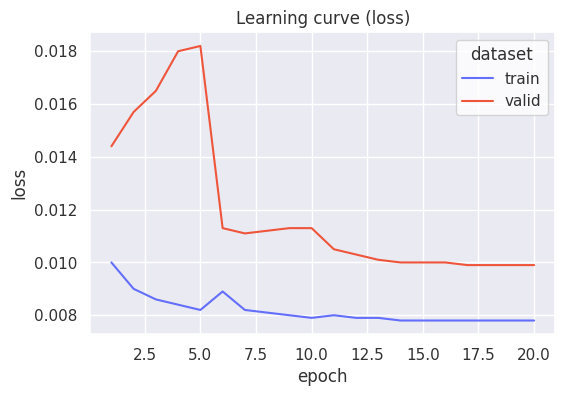

In [41]:
sns.lineplot(data=mlp_model.history, x="epoch", y="loss", hue="dataset")
plt.title("Learning curve (loss)");

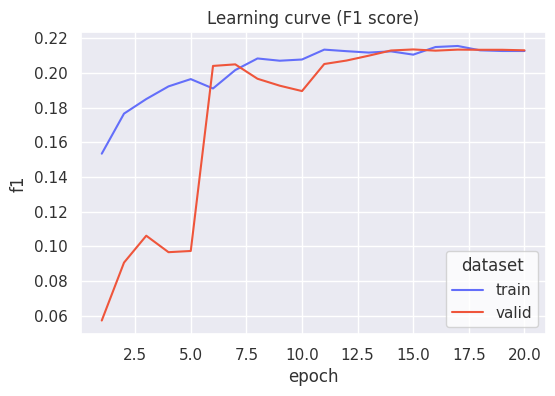

In [42]:
sns.lineplot(data=mlp_model.history, x="epoch", y="f1", hue="dataset")
plt.title("Learning curve (F1 score)");

f1: 0.213, precision: 0.139, recall: 0.459, avg_precision_score: 0.122


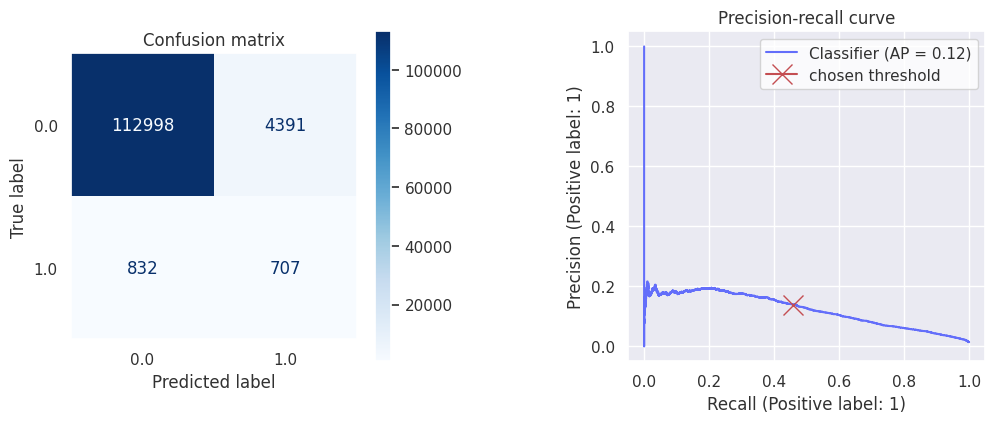

In [43]:
mlp_model.evaluate(x_valid, y_valid)

---